## Missing and spurious interactions and the reconstruction of complex networks
### Information theory course, Physics of Data, Unipd 
#### Amirhossein Rostami - 2084299

Our aim is to reliably identify both
missing and spurious interactions in noisy network observations. The approach also enables us to obtain, from those
noisy observations, network reconstructions that yield estimates
of the true network properties that are more accurate than those
provided by the observations themselves

 Specifically, we show that within
our framework we can reliably identify false negatives (missing interactions) and false positives (spurious interactions) 


$$ p(X = x | A^O) = \int_{M}  p(X = x | M) p(M | A^O) dM $$



 $ p(X = x|M) $  is the probability that X = x in a network
generated with model M

Using Bayes Theorem we can rewrite : 

$$ p(X = x | A^O) = \frac{\int_{\mathcal{M}} \, dM \, p(X = x | M) \, p(A^O | M) \, p(M)}{\int_{\mathcal{M}} \, dM \, p(A^O | M') \, p(M')} $$




Where $p(A^O|M)$ is the probability that model $M$ gives rise to $A^O$ among all possible adjacency matrices, and $p(M)$ is the a priori probability that model $M$ is the correct one. We call $p(X = x|A^O)$ the reliability of the $X = x$ measurement.


$$
\text{{Where:}} \\
\text{{- The sum }} \sum_{P \in \mathcal{P}} \text{{ is over partitions }} P \text{{ in the space }} \mathcal{P} \text{{ of all possible partitions of the network into groups.}} \\
\text{{- }} \sigma_i \text{{ is the group to which node }} i \text{{ belongs in partition }} P. \\
\text{{- }} l_{\alpha \beta}^O \text{{ is the number of links in the observed network between groups }} \alpha \text{{ and }} \beta. \\
\text{{- }} r_{\alpha \beta} \text{{ is the maximum possible number of links between groups }} \alpha \text{{ and }} \beta.
$$



$$
H(P) = \sum_{\alpha \leq \beta} \left[ \ln(r_{\alpha \beta} + 1) + \ln\left( \binom{r_{\alpha \beta}}{l^O_{\alpha \beta}} \right) \right]

$$


$$
Z = \sum_{P \in \mathcal{P}} \exp[-\mathcal{H}(P)]
$$



## Sampling Paritions: 
start by placing each of the N nodes in a group

At each step we select a random node and attempt to move it to a randomly selected group

To decide whether we accept the move, we calculate the change

ΔH : If ΔH ≤ 0, the change is automatically accepted; otherwise, the
change is accepted with probability exp(−ΔH).

Import Libraries 

In [1]:
import numpy as np
import random
from math import comb, exp, log
import numpy as np
import networkx as nx
from scipy.special import comb
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
import pickle
from IPython.display import Image

Genreal Functions 

In [27]:


def initialize_network_uniform(N,num_groups): # randomly assigns groups for nodes 

    partition = {i: random.randint(0, num_groups - 1) for i in range(N)}  # Each node in the given number of the groups 
    return partition

def calculate_H(partition, adj_matrix):

    groups = set(partition.values())
    l = {}
    r = {}
    for g1 in groups:
        for g2 in groups:
            l[(g1, g2)] = 0
            r[(g1, g2)] = 0

    for i in range(len(adj_matrix)):
        for j in range(i, len(adj_matrix)):
            if partition[i] == partition[j]:
                group_pair = (partition[i], partition[j])
                r[group_pair] += 1
                if adj_matrix[i, j] == 1:
                    l[group_pair] += 1
            else:
                group_pair = (partition[i], partition[j])
                r[group_pair] += 1
                if adj_matrix[i, j] == 1:
                    l[group_pair] += 1

    H = 0
    for (g1, g2) in l.keys():
        if r[(g1, g2)] > 0:
            H += log(r[(g1, g2)] + 1) + log(comb(r[(g1, g2)], l[(g1, g2)]))
    
    return H

def metropolis_step(partition, adj_matrix, num_groups): # performs metropolis algorithm step 

    N = len(adj_matrix)
    node = random.choice(list(partition.keys()))
    current_group = partition[node]
    new_group = random.choice(list(set(range(num_groups)) - {current_group}))

    old_H = calculate_H(partition, adj_matrix)
    partition[node] = new_group
    new_H = calculate_H(partition, adj_matrix)

    delta_H = new_H - old_H

    if delta_H <= 0 or random.random() < exp(-delta_H ):
        return partition, new_H
    else:
        partition[node] = current_group
        return partition, old_H

def simulate_partitioning(adj_matrix, iterations, num_groups): # generates a partition based on the number of iterations 

    N = len(adj_matrix)
    partition = initialize_network_uniform(N, num_groups)
    H_values = []
    H = calculate_H(partition, adj_matrix)
    H_values.append(H)

    for _ in range(iterations):
        partition, H = metropolis_step(partition, adj_matrix, num_groups)
        H_values.append(H)
    
    return partition, H_values

def calculate_link_reliability(adj_matrix, partitions): # calculates the link reliability of the partitions generated 

    N = len(adj_matrix)
    link_reliability = np.zeros((N, N))
    Z = len(partitions)

    for partition in partitions:
        groups = set(partition.values())
        l = {}
        r = {}
        for g1 in groups:
            for g2 in groups:
                l[(g1, g2)] = 0
                r[(g1, g2)] = 0

        for i in range(N):
            for j in range(i, N):
                if partition[i] == partition[j]:
                    group_pair = (partition[i], partition[j])
                    r[group_pair] += 1
                    if adj_matrix[i, j] == 1:
                        l[group_pair] += 1
                else:
                    group_pair = (partition[i], partition[j])
                    r[group_pair] += 1
                    if adj_matrix[i, j] == 1:
                        l[group_pair] += 1

        for i in range(N):
            for j in range(i, N):
                if partition[i] == partition[j]:
                    group_pair = (partition[i], partition[j])
                    link_reliability[i, j] += (l[group_pair] + 1) / (r[group_pair] + 2)
                else:
                    group_pair = (partition[i], partition[j])
                    link_reliability[i, j] += (l[group_pair] + 1) / (r[group_pair] + 2)

    link_reliability /= Z
    return link_reliability


def generate_observed_network(A_T, p_remove=0.1, p_add=0.1): # generates observed network given true network with the probabilities of adding and removing 
 
    A_O = A_T.copy()
    N = len(A_T)
    
    # Remove random links
    for i in range(N):
        for j in range(i + 1, N):
            if A_T[i, j] == 1 and random.random() < p_remove:
                A_O[i, j] = 0
                A_O[j, i] = 0
    
    # Add random links
    for i in range(N):
        for j in range(i + 1, N):
            if A_T[i, j] == 0 and random.random() < p_add:
                A_O[i, j] = 1
                A_O[j, i] = 1
                
    return A_O






### Results for Dolphins Network 

In [73]:

graph = ig.load("dolphins.gml")
adjacency_matrix = graph.get_adjacency()
adjacency_matrix =np.array(adjacency_matrix)
A_T = adjacency_matrix
A_O = generate_observed_network(A_T=A_T,p_remove=0.3,p_add=0.3)

Plotting for H change during the simulation 

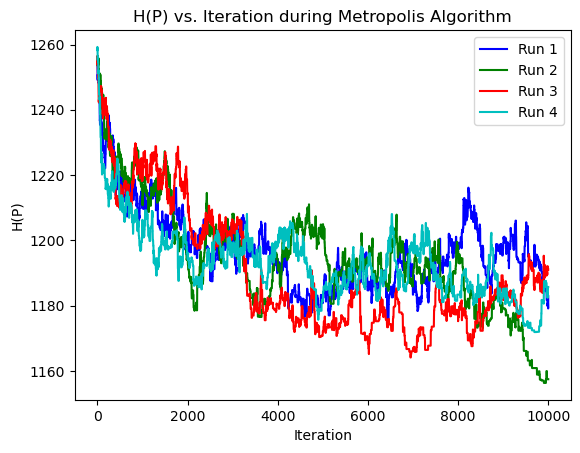

In [29]:
iterations = 10000
H_values_all = []
for _ in range(4):
    final_partition, H_values = simulate_partitioning(A_O, iterations,5)
    H_values_all.append(H_values)


colors = ['b', 'g', 'r', 'c']
for i in range(4):
    plt.plot(H_values_all[i], color=colors[i], label=f'Run {i+1}')

plt.xlabel('Iteration')
plt.ylabel('H(P)')
plt.title('H(P) vs. Iteration during Metropolis Algorithm')
plt.legend()
plt.show()



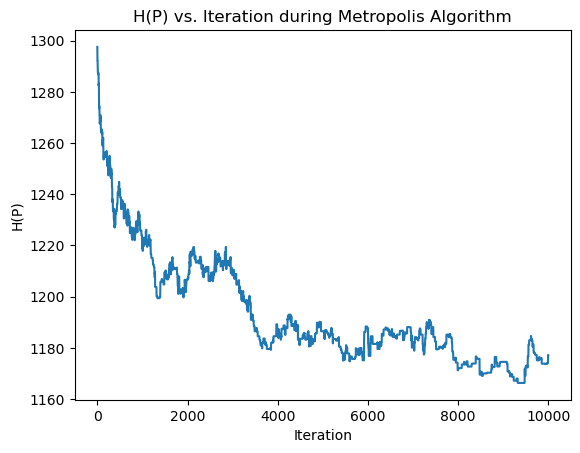

In [79]:
iterations = 10000
final_partition, H_values = simulate_partitioning(A_O, iterations, 10)

# Plot the values of H during the Metropolis algorithm
plt.plot(H_values)
plt.xlabel('Iteration')
plt.ylabel('H(P)')
plt.title('H(P) vs. Iteration during Metropolis Algorithm')
plt.show()

In [33]:
partitions = [simulate_partitioning(A_O, 1000,10)[0] for _ in range(100)]

### Missing Interactions (Removing Links)

To quantitatively study missing interactions, we generate observed networks AO by removing random links from the true network AT. 

We then estimate the link reliability RL ij for each of
these false negatives (AO ij = 0 and AT ij = 1), as well as for the
true negatives (AO ij = 0 and AT ij = 0).

 We measure the algorithm’s
ability to identify missing interactions by ranking the reliabilities
(in decreasing order) and calculating the probability that a false
negative has a higher ranking than a true negative (11).

 Similarly,
we quantify the ability to identify spurious interactions by adding
random links to the true network, obtaining and ranking the link
reliabilities (again, in decreasing order), and calculating the probability that a false positive (AO ij = 1 and AT ij = 0) is ranked lower
than a true positive (AO ij = 1 and AT ij = 1).

In [38]:
def evaluate_reliability(A_T, A_O, link_reliability):
    false_negatives = []
    true_negatives = []
    false_positives = []
    true_positives = []
    
    N = len(A_T)
    for i in range(N):
        for j in range(i + 1, N):
            if A_O[i, j] == 0 and A_T[i, j] == 1:
                false_negatives.append(link_reliability[i, j])
            elif A_O[i, j] == 0 and A_T[i, j] == 0:
                true_negatives.append(link_reliability[i, j])
            elif A_O[i, j] == 1 and A_T[i, j] == 0:
                false_positives.append(link_reliability[i, j])
            elif A_O[i, j] == 1 and A_T[i, j] == 1:
                true_positives.append(link_reliability[i, j])
    
    # Sorting  reliabilities in decreasing order
    false_negatives.sort(reverse=True)
    true_negatives.sort(reverse=True)
    false_positives.sort(reverse=True)
    true_positives.sort(reverse=True)
    

    # print("Sorted False Negatives (Decreasing Reliability):", false_negatives)
    # print("Sorted True Negatives (Decreasing Reliability):", true_negatives)
    # print("Sorted False Positives (Decreasing Reliability):", false_positives)
    # print("Sorted True Positives (Decreasing Reliability):", true_positives)
    
    # Calculate missing interaction accuracy
    if len(false_negatives) == 0 or len(true_negatives) == 0:
        missing_accuracy = 0
    else:
        count = sum(1 for fn in false_negatives for tn in true_negatives if fn > tn)
        missing_accuracy = count / (len(false_negatives) * len(true_negatives))
    
    # Calculate spurious interaction accuracy
    if len(false_positives) == 0 or len(true_positives) == 0:
        spurious_accuracy = 0
    else:
        count = sum(1 for fp in false_positives for tp in true_positives if fp < tp)
        spurious_accuracy = count / (len(false_positives) * len(true_positives))
    
    return missing_accuracy, spurious_accuracy

In [39]:
def generate_observed_network_removal(A_T, fraction_remove):
    A_O = A_T.copy()
    N = len(A_T)
    num_links_to_remove = int(fraction_remove * np.sum(A_T) / 2)
    existing_links = [(i, j) for i in range(N) for j in range(i + 1, N) if A_T[i, j] == 1]
    random.shuffle(existing_links)
    for i, j in existing_links[:num_links_to_remove]:
        A_O[i, j] = 0
        A_O[j, i] = 0
    return A_O

def generate_observed_network_addition(A_T, fraction_add):
    A_O = A_T.copy()
    N = len(A_T)
    num_links_to_add = int(fraction_add * N * (N - 1) / 2)
    non_existing_links = [(i, j) for i in range(N) for j in range(i + 1, N) if A_T[i, j] == 0]
    random.shuffle(non_existing_links)
    for i, j in non_existing_links[:num_links_to_add]:
        A_O[i, j] = 1
        A_O[j, i] = 1
    return A_O

In [56]:
def run_trials_and_plot(A_T, iterations, fractions, num_trials=10, removal=True):
    avg_missing_accuracies = []
    avg_spurious_accuracies = []

    for fraction in fractions:
        missing_accuracies = []
        spurious_accuracies = []

        for _ in range(num_trials):


            if removal:
                A_O = generate_observed_network_removal(A_T, fraction)
            else:
                A_O = generate_observed_network_addition(A_T, fraction)

            partitions = [simulate_partitioning(A_O, iterations,5)[0] for _ in range(100)]
            link_reliability = calculate_link_reliability(A_O, partitions)
            missing_acc, spurious_acc = evaluate_reliability(A_T, A_O, link_reliability)
            missing_accuracies.append(missing_acc)
            spurious_accuracies.append(spurious_acc)

        avg_missing_accuracies.append(np.mean(missing_accuracies))
        avg_spurious_accuracies.append(np.mean(spurious_accuracies))

    plt.figure(figsize=(10, 6))
    if removal: 
        plt.plot(fractions, avg_missing_accuracies, label='Missing Accuracy', marker='o')
        plt.xlabel('Fraction of Links Removed')
        plt.title('Accuracy of Missing Interactions')
    else:

        plt.plot(fractions, avg_spurious_accuracies, label='Spurious Accuracy', marker='o')
        plt.xlabel('Fraction of Links Added')
    plt.ylabel('Accuracy')
    
    plt.legend()
    plt.grid(True)
    plt.show()

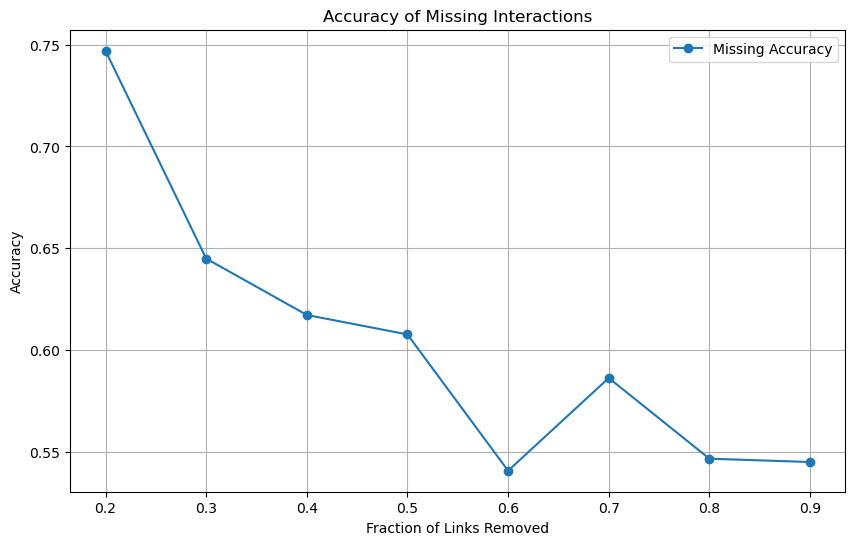

In [67]:
fractions = np.linspace(0.2, 0.9, 8)
run_trials_and_plot(A_T,500,fractions,1)

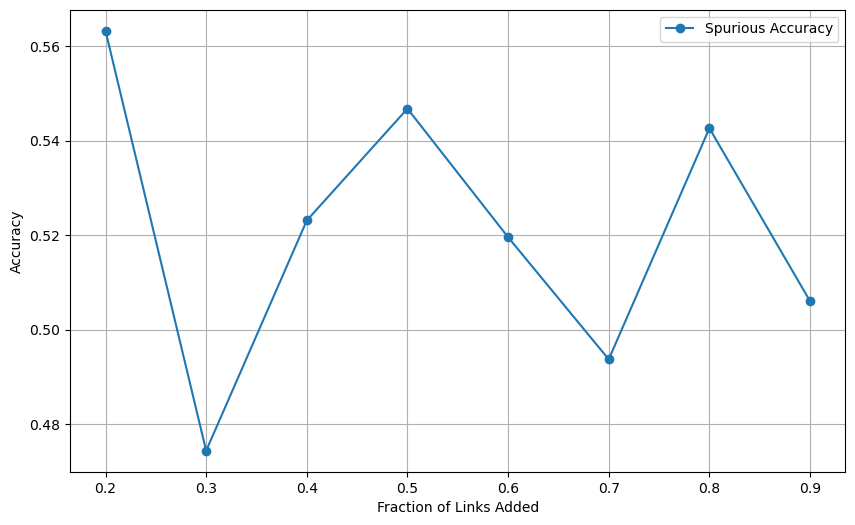

In [68]:
fractions = np.linspace(0.2, 0.9, 8)
run_trials_and_plot(A_T=A_T,iterations=500,fractions=fractions,num_trials=1,removal=False)

![Dolphins Network ](dolphins%20.png)


## Results for Karate Club Network 


In [70]:
# importing the first graph 
graph = ig.load("karate.gml")
adjacency_matrix = graph.get_adjacency()
adjacency_matrix =np.array(adjacency_matrix)
A_T = adjacency_matrix
A_O = generate_observed_network(A_T=A_T,p_remove=0.3,p_add=0.3)

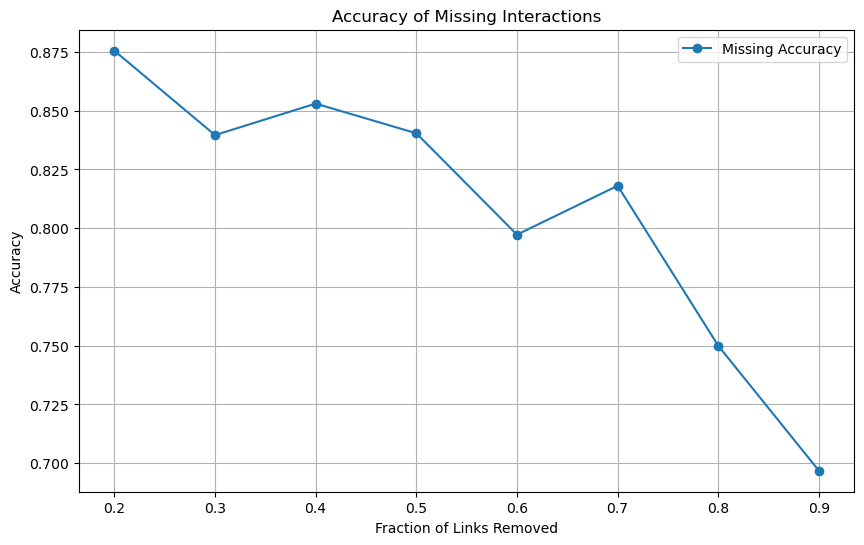

In [71]:
fractions = np.linspace(0.2, 0.9, 8)
run_trials_and_plot(A_T,500,fractions,1)

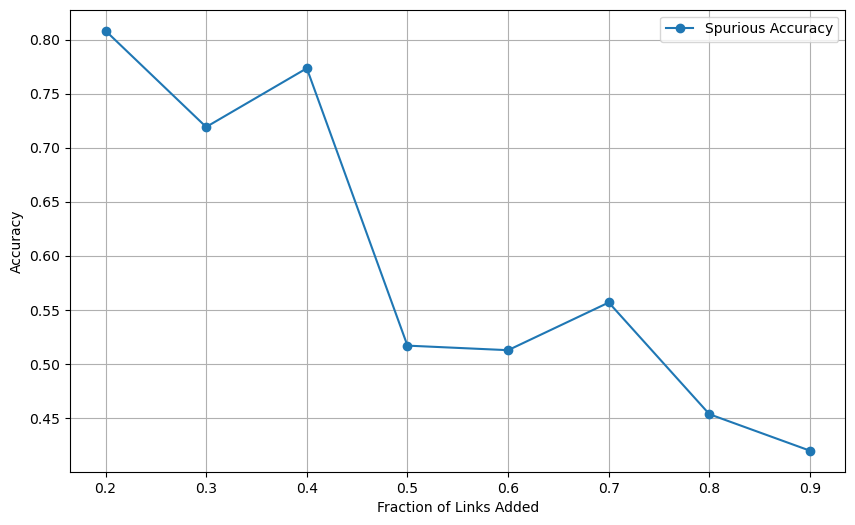

In [72]:
fractions = np.linspace(0.2, 0.9, 8)
run_trials_and_plot(A_T=A_T,iterations=500,fractions=fractions,num_trials=1,removal=False)

![karateclub](karateclub.png)
